In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num = [0,1,2,3,4]

path = 'datasets/MHC_I_el_allele_specific/HLA-A01:01/'
files = [path+'c00%d' % i for i in num]

files

['datasets/MHC_I_el_allele_specific/HLA-A01:01/c000',
 'datasets/MHC_I_el_allele_specific/HLA-A01:01/c001',
 'datasets/MHC_I_el_allele_specific/HLA-A01:01/c002',
 'datasets/MHC_I_el_allele_specific/HLA-A01:01/c003',
 'datasets/MHC_I_el_allele_specific/HLA-A01:01/c004']

In [8]:
data = [np.loadtxt(f, dtype = 'str') for f in files]
data = np.vstack(data)

In [9]:
data

array([['AAAAAAAFPSLP', '0.000000'],
       ['AAAAAAAGAAGKET', '0.000000'],
       ['AAAAAAAGAAVLP', '0.000000'],
       ...,
       ['YYYYNGYNNYNYN', '0.000000'],
       ['cLDTAQRNLY', '1.000000'],
       ['mQQKLVDQNIFSFY', '1.000000']], dtype='<U14')

In [9]:
x = data[:,0]

In [15]:
y = data[:,1].astype('float32')

In [16]:
y

array([0., 0., 0., ..., 0., 1., 1.], dtype=float32)

In [81]:
pep_len = []
for i in range(len(x)):
    length = len(x[i])
    pep_len.append(length)

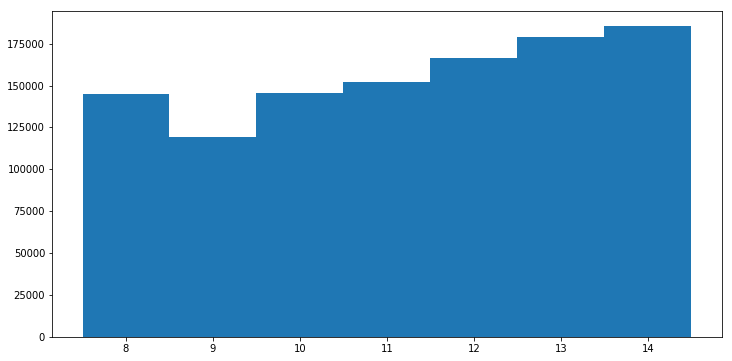

In [82]:
plt.figure(figsize=(12,6))
plt.hist(pep_len, bins = np.arange( min(pep_len) - 0.5 ,
                     max( pep_len ) + 1.5 , 1.0 ))
plt.show()

In [83]:
positive_num = 0
for i in range(len(y)):
    if y[i] == 1:
        positive_num +=1 

In [86]:
positive_num

10473